In [1]:
import sys
import platform
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platfsorm: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platfsorm: macOS-13.4-arm64-arm-64bit
PyTorch Version: 2.0.1

Python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [2]:
# Experiment Details (see Setup and Background)
P = 113 # (a+b) mod P
n_tokens = P+1 # 0,...,P-1,'='
seq_len = 3 # a,b,'='
d_embed = 128 # token embedding dimension (also need "learned positional embeddings")
n_heads = 4 # number of attention heads
d_mlp = 512 # hidden units in MLP
train_split = .3 # use only 30% of all possible pairs to train model
n_layers = 1 # only decoder layers

# Preprocessing

In [3]:
input_vals = np.arange(P)  # Array of input numbers from 0 to P-1

# Create a grid of all possible pairs of digits
pairs = np.meshgrid(input_vals, input_vals)

# Reshape the arrays and stack them horizontally to create a 2D array of pairs
pairs_array = np.column_stack((pairs[0].ravel(), pairs[1].ravel()))
output_array = np.mod(np.sum(pairs_array,axis=1),P)

eq_col = np.ones(len(pairs_array))*P # column of P,...,P since P = '='
input_array = np.concatenate((pairs_array,eq_col.reshape((len(eq_col),1))),axis=1)
assert(input_array.shape==(P**2,3))
assert(output_array.shape==(P**2,))

In [4]:
class MTDataset(torch.utils.data.Dataset):
  def __init__(self):
    # import and initialize dataset    
    self.source = np.array(input_array, dtype=int)
    self.target = np.array(output_array, dtype = int)
    
  def __getitem__(self, idx):
    # get item by index
    return self.source[idx], self.target[idx]
  
  def __len__(self):
    # returns length of data
    return len(self.source)

In [5]:
np.random.seed(42)
dataset = MTDataset()
NUM_INSTANCES = len(dataset)
TEST_RATIO = 0.7
TEST_SIZE = int(NUM_INSTANCES * TEST_RATIO)

BATCH_SIZE=NUM_INSTANCES-TEST_SIZE # FULL BATCH = TRAIN SIZE
assert(P**2==NUM_INSTANCES)

In [6]:
torch.manual_seed(21)

In [7]:
indices = list(range(NUM_INSTANCES))

test_idx = np.random.choice(indices, size = TEST_SIZE, replace = False)
train_idx = list(set(indices) - set(test_idx))
train_sampler, test_sampler = torch.utils.data.SubsetRandomSampler(train_idx), torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)

# Model and Training

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0, max_len=seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [9]:
class TransformerNet(nn.Module):
    def __init__(self,n_tokens,seq_len,d_embed,d_mlp,n_heads):
        super(TransformerNet,self).__init__()
        self.We = nn.Embedding(n_tokens,d_embed)
        # self.Pe = PositionalEncoding(d_embed, max_len = seq_len)
        self.Pe = nn.Parameter(torch.randn(seq_len, d_embed)/np.sqrt(d_embed))
        
        # Decoder: Attention head
        self.attn1 = nn.MultiheadAttention(d_embed,n_heads,dropout=0,bias=False,batch_first=True)
        # Decoder: MLP
        self.lin1 = nn.Linear(d_embed,d_mlp)
        self.lin2 = nn.Linear(d_mlp,d_embed)
        
        # Unembedding (not tied to embedding)
        self.Wu = nn.Linear(d_embed,n_tokens,bias=False)
        
    def forward(self,src):
        # token
        x = self.We(src)
        x = x+self.Pe[:x.shape[-2]]
        # token embedding + positional embedding
        x = x[:,2]+self.attn1(x,x,x,need_weights=False)[0][:,2]
        # residual stream from first two tokens is irrelevant once '=' has attended to those tokens, so we only consider idx=2
        x = x+self.lin2(F.relu(self.lin1(x)))
        # feed-forward (MLP) part of decoder
        logits = self.Wu(x)
        return logits

In [10]:
model = TransformerNet(n_tokens,seq_len,d_embed,d_mlp,n_heads)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay=1.0, betas=(0.9,0.98))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

In [11]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
acc = lambda lgits,truth: (torch.sum(torch.argmax(lgits,1)==truth)/len(lgits)).item()

In [12]:
def train_model(n_epochs):
    for epoch in tqdm(range(n_epochs)):
        # train loss
        x,y = next(iter(train_loader))
        logits = model(x).to(torch.float64)
        loss = criterion(logits,y)
        
        train_loss.append(loss.item())
        train_acc.append(acc(logits,y))
        
        # test loss
        x,y = next(iter(test_loader))
        logits = model(x)
        loss2 = criterion(logits,y)
        test_loss.append(loss2.item())
        test_acc.append(acc(logits,y))
        
        # backprop

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

# Results

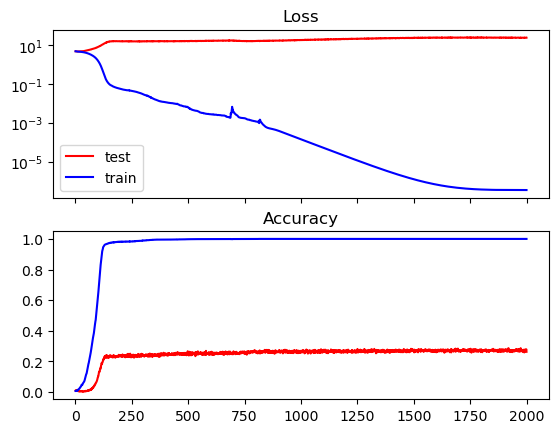

In [14]:
# train_model(2000)
fig,ax = plt.subplots(2,1,sharex=True)
NUM_EPOCHS = len(test_loss)
ax[0].set_title("Loss")
ax[0].plot(range(1, NUM_EPOCHS+1), test_loss, 'r-',label='test')
ax[0].plot(range(1, NUM_EPOCHS+1), train_loss, 'b-',label='train')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].set_title("Accuracy")
ax[1].plot(range(1, NUM_EPOCHS+1), test_acc, 'r-')
ax[1].plot(range(1, NUM_EPOCHS+1), train_acc, 'b-')
plt.show()